## MOUNTING GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## COPYING THE ZIPPED DATA TO COLAB

In [ ]:
!cp "/content/drive/MyDrive/AttentionEEG.zip" "/content/AttentionEEG.zip"

## UNZIP DATA

In [ ]:
!unzip /content/AttentionEEG.zip -d /content/extracted_files

Archive:  /content/AttentionEEG.zip
   creating: /content/extracted_files/Attention_EEG/
   creating: /content/extracted_files/Attention_EEG/audio1/
  inflating: /content/extracted_files/Attention_EEG/audio1/Attention_Analysis_audio_Subject-1_EPOCX_243125_2024.10.31T17.07.20+05.30.json  
  inflating: /content/extracted_files/Attention_EEG/audio1/Attention_Analysis_audio_Subject-1_EPOCX_243125_2024.10.31T17.07.20+05.30.mc.pm.fe.bp.csv  
  inflating: /content/extracted_files/Attention_EEG/audio1/Attention_Analysis_audio_Subject-1_EPOCX_243125_2024.10.31T17.07.20+05.30_intervalMarker.csv  
   creating: /content/extracted_files/Attention_EEG/audio2/
  inflating: /content/extracted_files/Attention_EEG/audio2/Attention_Analysis_audio_subject2_EPOCX_243401_2024.11.03T15.35.51+05.30.json  
  inflating: /content/extracted_files/Attention_EEG/audio2/Attention_Analysis_audio_subject2_EPOCX_243401_2024.11.03T15.35.51+05.30.mc.pm.fe.bp.csv  
  inflating: /content/extracted_files/Attention_EEG/audio

## INSTALLING REQUIRED LIBRARIES

In [ ]:
#@title Run this cell and the cells below. This might take a few minutes.
%%capture
%pip install scipy
%pip install seaborn
%pip install mne
%pip install python-picard

import mne
import numpy as np

# System Imports
import os
from glob import glob
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Common Imports
import pandas as pd
import numpy as np

# MNE: EEG Analysis Library
from mne import Epochs,find_events

# Specific MNE Imports
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.preprocessing import ICA

# Install some necessary packages
%pip install psychopy brainflow
!apt install xvfb -y
%pip install pyvirtualdisplay
%pip install piglet
%pip install mne pywavelets matplotlib
import pywt

# Set up virtual display
# (Source: https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

from collections import OrderedDict

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
!ls /content/extracted_files/Attention_EEG/

audio1	audio4	audio7	text10	text4  text7  video1   video3  video6  video9
audio2	audio5	audio8	text2	text5  text8  video10  video4  video7
audio3	audio6	text1	text3	text6  text9  video2   video5  video8


In [ ]:
# Path to the parent folder containing 28 folders
parent_folder = "/content/extracted_files/Attention_EEG/"

In [ ]:
import gc  # Garbage collector to free memory

# Function to load CSV with the second row as the header
def load_csv_skip_first_row(file_path):
    return pd.read_csv(file_path, skiprows=1)

# Dictionary to store file paths instead of actual dataframes
audio_files = {}
video_files = {}
text_files = {}

# Base folder path (update this with your actual path)
base_folder = "/content/extracted_files/Attention_EEG/"
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".csv") and "intervalMarker" not in file:
                file_path = os.path.join(folder_path, file)

                # Store file paths in appropriate dictionaries
                if "audio" in folder.lower():
                    audio_files[folder] = file_path
                elif "video" in folder.lower():
                    video_files[folder] = file_path
                elif "text" in folder.lower():
                    text_files[folder] = file_path

# Debugging: Print how many files are found for each modality
print(f"Audio files found: {len(audio_files)}")
print(f"Video files found: {len(video_files)}")
print(f"Text files found: {len(text_files)}")

# Function to process and check each file one at a time
def process_file(file_path):
    print(f"Processing: {file_path}")
    df = load_csv_skip_first_row(file_path)
    print(f"Columns: {df.columns.tolist()}")
    if "MarkerValueInt" in df.columns:
        print("MarkerValueInt found!")
    else:
        print("Warning: MarkerValueInt not found!")
    del df  # Delete the dataframe to free memory
    gc.collect()  # Garbage collection to avoid memory issues

# Example: Process the first few audio files
for folder, file_path in list(audio_files.items())[:3]:  # Adjust the range as needed
    process_file(file_path)

print("Finished processing sample files.")


Audio files found: 8
Video files found: 10
Text files found: 10
Processing: /content/extracted_files/Attention_EEG/audio5/Attention_Analysis_audio_subject5_EPOCX_2024.11.04T19.00.34+05.30.mc.pm.fe.bp.csv
Columns: ['Timestamp', 'OriginalTimestamp', 'EEG.Counter', 'EEG.Interpolated', 'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4', 'EEG.RawCq', 'EEG.Battery', 'EEG.BatteryPercent', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'EEG.MarkerHardware', 'CQ.AF3', 'CQ.F7', 'CQ.F3', 'CQ.FC5', 'CQ.T7', 'CQ.P7', 'CQ.O1', 'CQ.O2', 'CQ.P8', 'CQ.T8', 'CQ.FC6', 'CQ.F4', 'CQ.F8', 'CQ.AF4', 'CQ.Overall', 'EQ.SampleRateQuality', 'EQ.OVERALL', 'EQ.AF3', 'EQ.F7', 'EQ.F3', 'EQ.FC5', 'EQ.T7', 'EQ.P7', 'EQ.O1', 'EQ.O2', 'EQ.P8', 'EQ.T8', 'EQ.FC6', 'EQ.F4', 'EQ.F8', 'EQ.AF4', 'MC.Action', 'MC.ActionPower', 'MC.IsActive', 'PM.Attention.IsActive', 'PM.Attention.Scaled', 'PM.Attention.Raw', 'PM.Attention.Min', 'PM.Atte

In [ ]:
audio_files['audio1']

'/content/extracted_files/Attention_EEG/audio1/Attention_Analysis_audio_Subject-1_EPOCX_243125_2024.10.31T17.07.20+05.30.mc.pm.fe.bp.csv'

In [ ]:
import pandas as pd
import gc  # Garbage collector to free memory

# Function to load CSV with the second row as the header
def load_csv_skip_first_row(file_path):
    return pd.read_csv(file_path, skiprows=1)

# Function to apply baseline correction
def baseline_correction(data_df):
    # Find the indices for the first marker with value 1 (eyes open start)
    try:
        eyes_open_start_idx = data_df.index[data_df['MarkerValueInt'] == 1][0]
        # Find the last marker with value 3 (eyes closed end)
        eyes_closed_end_idx = data_df.index[data_df['MarkerValueInt'] == 3][-1]
    except IndexError:
        print("Error: Marker values 1 or 3 not found.")
        return data_df  # If markers are missing, return the original data

    # Extract baseline data between these markers
    baseline_df = data_df.iloc[eyes_open_start_idx:eyes_closed_end_idx + 1]

    # Compute the mean for each EEG channel during the baseline period
    baseline_mean = baseline_df.mean(axis=0)

    # Apply baseline correction to the entire data (subtract baseline mean)
    corrected_data = data_df - baseline_mean

    return corrected_data

# Dictionary to store file paths instead of actual dataframes
audio_corrected = {}
video_corrected = {}
text_corrected = {}

# Base folder path (update this with your actual path)
base_folder = "/content/extracted_files/Attention_EEG/"

# Process files for each modality
for folder, file_path in list(audio_files.items()) + list(video_files.items()) + list(text_files.items()):
    print(f"Processing {folder} file: {file_path}")

    # Load data
    df = load_csv_skip_first_row(file_path)

    # Apply baseline correction
    corrected_df = baseline_correction(df)

    # Store the corrected data in the corresponding dictionary
    if "audio" in folder.lower():
        audio_corrected[folder] = corrected_df
    elif "video" in folder.lower():
        video_corrected[folder] = corrected_df
    elif "text" in folder.lower():
        text_corrected[folder] = corrected_df

    # Free memory by deleting the original dataframe and invoking garbage collection
    del df
    gc.collect()

print("Baseline correction completed for all files.")


Processing audio5 file: /content/extracted_files/Attention_EEG/audio5/Attention_Analysis_audio_subject5_EPOCX_2024.11.04T19.00.34+05.30.mc.pm.fe.bp.csv
Processing audio3 file: /content/extracted_files/Attention_EEG/audio3/Attention_Ananlysis_aud_subject3_EPOCX_2024.11.03T22.09.28+05.30.mc.pm.fe.bp.csv
Processing audio8 file: /content/extracted_files/Attention_EEG/audio8/Attention_Analysis_audio_subject8_EPOCX_2024.11.06T14.48.11+05.30.mc.pm.fe.bp.csv
Processing audio7 file: /content/extracted_files/Attention_EEG/audio7/Attention_Analysis_audio_subject7_EPOCX_2024.11.05T19.27.58+05.30.mc.pm.fe.bp.csv
Processing audio4 file: /content/extracted_files/Attention_EEG/audio4/Attention_Ananlysis_aud_subject4_EPOCX_2024.11.04T14.49.09+05.30.mc.pm.fe.bp.csv
Processing audio2 file: /content/extracted_files/Attention_EEG/audio2/Attention_Analysis_audio_subject2_EPOCX_243401_2024.11.03T15.35.51+05.30.mc.pm.fe.bp.csv
Processing audio1 file: /content/extracted_files/Attention_EEG/audio1/Attention_Ana

In [ ]:
audio_corrected['audio1']

,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,...,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma
0,-36.579071,-36.578907,83.35608,0.0,358.988275,125.337335,103.056050,68.608367,143.783389,-153.991404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-36.575167,-36.574903,84.35608,0.0,362.578118,121.491143,100.748433,68.352019,131.219424,-137.324900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-36.571263,-36.570999,85.35608,0.0,362.321771,118.798761,92.927632,62.326140,114.809268,-96.940135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-36.567359,-36.567095,86.35608,0.0,362.450189,116.747491,84.594624,54.505828,99.168154,-40.401560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-36.563455,-36.563191,87.35608,0.0,365.270501,113.029718,79.466206,47.838835,85.706729,15.752248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206784,770.717640,770.716794,19.35608,0.0,-9.857429,27.132257,1.902241,5.659636,-73.652646,-9.632517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206785,770.721544,770.720598,20.35608,0.0,-15.370612,22.773370,-8.097759,0.915984,-74.550107,-8.863474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206786,770.725448,770.724502,21.35608,0.0,-16.652350,18.670343,-13.867290,-3.186555,-74.806455,-5.273631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206787,770.729352,770.728506,22.35608,0.0,-11.652350,19.952569,-11.174907,-2.289094,-73.011533,-2.324900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import os
import gc
from scipy.signal import butter, filtfilt

# Bandpass filter: 4-45 Hz
def bandpass_filter(data, lowcut=4, highcut=45, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Remove leading apostrophe from string data
def clean_data(df):
    # Apply string cleaning to all columns except 'Timestamp'
    for col in df.columns:
        if df[col].dtype == 'object':  # Only apply cleaning to string columns
            df[col] = df[col].apply(lambda x: str(x).lstrip("'") if isinstance(x, str) else x)
    return df

# Process and save the filtered data
def process_and_save_df(df, output_folder, folder_name):
    print(f"Processing DataFrame for: {folder_name}")

    # Clean the data to remove any leading apostrophes
    df = clean_data(df)

    # Keep only the relevant columns
    required_columns = ['Timestamp', 'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7',
                       'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
    df = df[required_columns]

    # Filter task-related data (after the last occurrence of 'MarkerValueInt' == 3)
    task_start_idx = df[df['Timestamp'] == 3].index[-1] + 1 if (df['Timestamp'] == 3).any() else 0
    df = df.iloc[task_start_idx:]  # Keep data from the task period onwards

    # Apply bandpass filter to all EEG columns
    for col in required_columns[1:]:  # Skip 'Timestamp'
        df[col] = bandpass_filter(df[col].values)

    # Create output directory for the specific data (e.g., audio1, video1, etc.)
    output_folder_path = os.path.join(output_folder, folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    # Save the processed DataFrame as CSV
    output_file_path = os.path.join(output_folder_path, f"{folder_name}_filtered.csv")
    df.to_csv(output_file_path, index=False)
    print(f"Saved processed file: {output_file_path}")

    del df  # Free memory
    gc.collect()

# Create output directory
output_folder = "/content/FilteredEEG"

# Process and save all DataFrames, assuming each entry in the dictionary is an individual data item like 'audio1', 'video1', etc.
for folder_name, df_dict in {'audio': audio_corrected, 'video': video_corrected, 'text': text_corrected}.items():
    for data_name, df in df_dict.items():
        process_and_save_df(df, output_folder, data_name)

print("All files processed and saved.")


Processing DataFrame for: audio5
Saved processed file: /content/FilteredEEG/audio5/audio5_filtered.csv
Processing DataFrame for: audio3
Saved processed file: /content/FilteredEEG/audio3/audio3_filtered.csv
Processing DataFrame for: audio8
Saved processed file: /content/FilteredEEG/audio8/audio8_filtered.csv
Processing DataFrame for: audio7
Saved processed file: /content/FilteredEEG/audio7/audio7_filtered.csv
Processing DataFrame for: audio4
Saved processed file: /content/FilteredEEG/audio4/audio4_filtered.csv
Processing DataFrame for: audio2
Saved processed file: /content/FilteredEEG/audio2/audio2_filtered.csv
Processing DataFrame for: audio1
Saved processed file: /content/FilteredEEG/audio1/audio1_filtered.csv
Processing DataFrame for: audio6
Saved processed file: /content/FilteredEEG/audio6/audio6_filtered.csv
Processing DataFrame for: video3
Saved processed file: /content/FilteredEEG/video3/video3_filtered.csv
Processing DataFrame for: video5
Saved processed file: /content/FilteredE

In [ ]:
!zip -r /content/FilteredEEG.zip /content/FilteredEEG

  adding: content/FilteredEEG/ (stored 0%)
  adding: content/FilteredEEG/audio5/ (stored 0%)
  adding: content/FilteredEEG/audio5/audio5_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/video3/ (stored 0%)
  adding: content/FilteredEEG/video3/video3_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/text9/ (stored 0%)
  adding: content/FilteredEEG/text9/text9_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/audio3/ (stored 0%)
  adding: content/FilteredEEG/audio3/audio3_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/video5/ (stored 0%)
  adding: content/FilteredEEG/video5/video5_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/audio8/ (stored 0%)
  adding: content/FilteredEEG/audio8/audio8_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/text4/ (stored 0%)
  adding: content/FilteredEEG/text4/text4_filtered.csv (deflated 53%)
  adding: content/FilteredEEG/text2/ (stored 0%)
  adding: content/FilteredEEG/text2/text2_filtered.csv (defl

In [ ]:
data = pd.read_csv("/content/FilteredEEG/audio1/audio1_filtered.csv")
data.head(3)

,Timestamp,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,-36.579071,-2.696696,5.376107,-3.798600,-0.899790,93.857598,10.575826,1.192930,9.577467,-2.104518,30.969800,6.222027,5.043166,5.319182,3.725593
1,-36.575167,-3.758041,5.559154,-5.633134,-1.371772,90.749424,18.819004,-8.230034,2.440189,-3.207585,36.817083,-8.077699,5.170895,-19.385156,1.247650
2,-36.571263,-4.537983,5.898856,-7.895468,-3.210277,87.336039,40.767103,-17.075138,-4.070137,-3.683112,42.323729,-16.391242,4.116390,-29.788539,-1.370206


In [ ]:
sampling_rate = 256
ch_names = ['EEG.AF3','EEG.F7','EEG.F3','EEG.FC5','EEG.T7','EEG.P7','EEG.O1','EEG.O2','EEG.P8','EEG.T8','EEG.FC6','EEG.F4','EEG.F8','EEG.AF4']
clean_ch_names = [ch.replace('EEG.', '') for ch in ch_names]
clean_ch_names

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

In [ ]:
eeg_Data = data[ch_names].to_numpy().T
eeg_Data.shape

(14, 206789)

In [ ]:
n_channels = len(clean_ch_names)
print(n_channels)


14


In [ ]:
info = mne.create_info(clean_ch_names, sfreq=sampling_rate, ch_types=['eeg']*n_channels)
raw = mne.io.RawArray(eeg_Data, info)
raw.set_eeg_reference('average', projection=True)
print(len(ch_names))
print(raw.info)

Creating RawArray with float64 data, n_channels=14, n_times=206789
    Range : 0 ... 206788 =      0.000 ...   807.766 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
14
<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: Average EEG reference: off
 sfreq: 256.0 Hz
>


In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)

<RawArray | 14 x 206789 (807.8 s), ~22.1 MiB, data loaded>

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


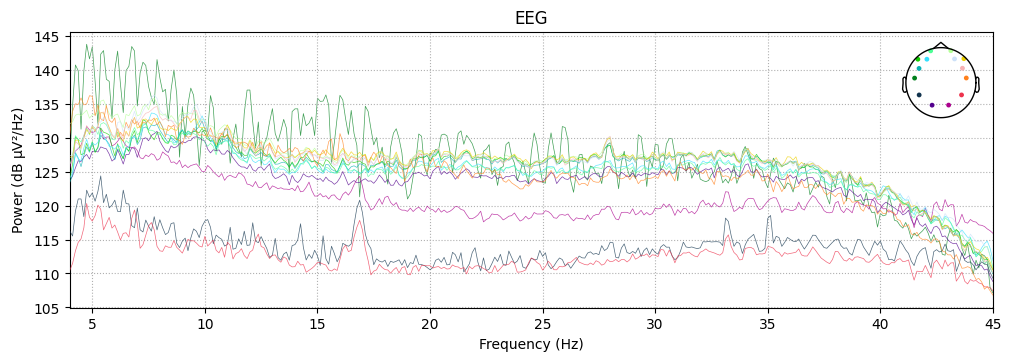

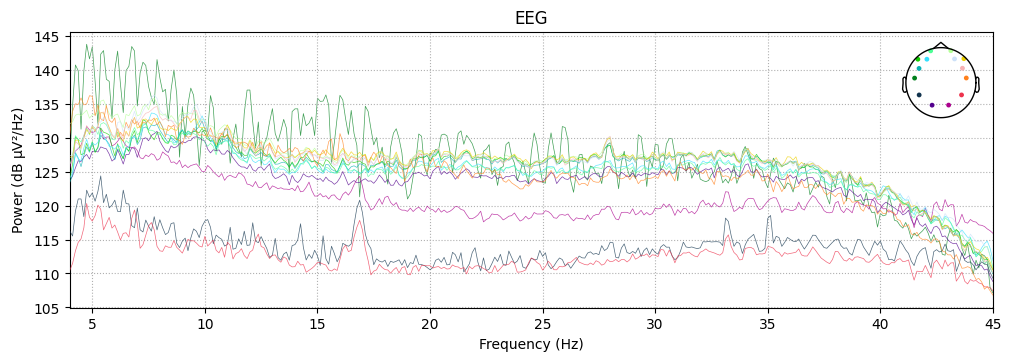

In [ ]:
raw.compute_psd(fmin = 4, fmax=45).plot()